# Modern Probabilistic Forecasting Methods

This notebook demonstrates end-to-end examples of important probabilistic forecasting methods and associated evaluations.

## 0) Common setup: data + utilities

Set `USE_REAL_DATA = False` (default) for a **synthetic dataset** or `True` for **ETTh1** (electricity transformer temperature — a widely-used research benchmark).

The synthetic DGP is deliberately realistic and **hard**: heteroscedastic noise, heavy tails (Student-t), occasional outliers, a structural break, holiday effects, and covariate interactions. This ensures different methods show genuine strengths and weaknesses.

In [ ]:
# All imports (consolidated) 

# Apple Silicon (MPS): some PyTorch ops aren't implemented for Metal yet.
# This fallback lets them run on CPU transparently. Must be set before `import torch`.
import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

import warnings
warnings.filterwarnings("ignore")

# Core
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Classical statistics
import statsmodels.api as sm

# Gradient boosting
import lightgbm as lgb

# Distributional boosting
from ngboost import NGBRegressor
from ngboost.distns import Normal

# scikit-learn utilities
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor

# ── PyTorch 2.6 compat ──────────────────────────────────────────────────
# Must patch torch.load BEFORE importing GluonTS / PL / pytorch-forecasting,
# because those libraries cache torch references at import time.
# PL passes weights_only=True explicitly, so we force-override it.
import torch, torch.serialization
def _torch_load_patched(*args, **kwargs):
    kwargs["weights_only"] = False          # force — we trust our own checkpoints
    return torch.serialization.load(*args, **kwargs)   # always the real impl
torch.load = _torch_load_patched

# GluonTS / DeepAR (Trainer removed in 0.16+; use trainer_kwargs instead)
from gluonts.dataset.common import ListDataset
from gluonts.torch.model.deepar import DeepAREstimator
from gluonts.torch.distributions import StudentTOutput
from gluonts.evaluation.backtest import make_evaluation_predictions

# PyTorch Forecasting / TFT
import lightning.pytorch as pl
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer, QuantileLoss
from pytorch_forecasting.data import GroupNormalizer

# Foundation model — Chronos-2
from chronos import Chronos2Pipeline

In [8]:
# ╔══════════════════════════════════════════════════════════════╗
# ║  DATASET TOGGLE — set to True to use real-world data       ║
# ╚══════════════════════════════════════════════════════════════╝
USE_REAL_DATA = False   # True → ETTh1 electricity benchmark; False → synthetic

rng = np.random.default_rng(7)

if USE_REAL_DATA:
    # ── ETTh1: Electricity Transformer Temperature ──
    # Widely used in forecasting research (Informer, Autoformer, PatchTST, …).
    # Hourly data resampled to daily. Target: OT (oil temperature).
    # Two covariates mapped to the same schema as the synthetic data:
    #   "promo" ← HUFL (High UseFul Load factor)
    #   "price" ← HULL (High UseLess Load factor)
    url = "https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTh1.csv"
    raw = pd.read_csv(url, parse_dates=["date"])
    daily = raw.set_index("date").resample("D").mean().dropna()

    df = daily[["OT", "HUFL", "HULL"]].rename(columns={
        "OT": "y", "HUFL": "promo", "HULL": "price"
    })
    df.index.name = "ds"

    h = 60  # forecast horizon
    train = df.iloc[:-h].copy()
    test  = df.iloc[-h:].copy()

    print(f"ETTh1 loaded: {len(df)} daily obs  |  train {len(train)}, test {len(test)}")
    print(f"  'promo' = HUFL (high useful load)   'price' = HULL (high useless load)")

else:
    # --- Realistic synthetic daily data ---
    # This DGP is deliberately "hard" so different methods show real strengths/weaknesses:
    #   - heteroscedastic noise  → constant-variance models (SARIMAX) will miscalibrate
    #   - heavy tails (Student-t) → Gaussian assumptions underestimate tail risk
    #   - occasional outliers     → tests robustness
    #   - structural break        → favours models that weight recent data
    #   - covariate interactions  → tree-based / deep models should outperform linear

    n = 900
    ds = pd.date_range("2022-01-01", periods=n, freq="D")
    t = np.arange(n)

    # ── Covariates ──
    promo = (rng.random(n) < 0.12).astype(int)
    price = 10 + 0.02*t + rng.normal(0, 0.4, n) - 0.8*promo

    # ── Deterministic components ──
    weekly  = 1.2 * np.sin(2*np.pi*t/7)
    yearly  = 2.0 * np.sin(2*np.pi*t/365.25)
    trend   = 0.01 * t

    # ── Structural break: level shift at ~day 500 (mid-2023) ──
    level_shift = 2.5 * (t >= 500).astype(float)

    # ── Holiday-like effects (Christmas/NY and Easter-ish windows) ──
    holidays = np.zeros(n)
    for i, d in enumerate(ds):
        if (d.month == 12 and d.day >= 23) or (d.month == 1 and d.day <= 2):
            holidays[i] = rng.uniform(3, 6)       # strong Christmas / New Year lift
        elif d.month == 4 and 10 <= d.day <= 17:
            holidays[i] = rng.uniform(1, 3)        # Easter-ish bump

    # ── Covariate effects with interaction ──
    promo_effect = 3.0*promo + 0.5*promo*(price - price.mean())   # promo x price interaction
    price_effect = -0.6 * price

    # ── Heteroscedastic noise: scale varies with local level ──
    base_level  = 20 + trend + yearly
    noise_scale = 0.8 + 0.06 * np.abs(base_level - base_level.mean())   # ranges ~0.8 – 2.0
    noise = rng.standard_t(df=5, size=n) * noise_scale                  # heavy tails (df=5)

    # ── Outliers: ~1.5% of days get a large shock ──
    outlier_mask = rng.random(n) < 0.015
    outliers = outlier_mask * rng.choice([-1, 1], size=n) * rng.uniform(4, 8, size=n)

    # ── Assemble target ──
    y = (20 + trend + weekly + yearly + level_shift
         + holidays + promo_effect + price_effect
         + noise + outliers)

    df = pd.DataFrame({"ds": ds, "y": y, "promo": promo, "price": price})
    df = df.set_index("ds")

    print(f"Synthetic: {len(df)} obs, range [{df['y'].min():.1f}, {df['y'].max():.1f}]")
    print(f"  Outlier days: {outlier_mask.sum()}, structural break at day 500")

    # --- train / test split ---
    h = 60  # forecast horizon
    train = df.iloc[:-h].copy()
    test  = df.iloc[-h:].copy()

Synthetic: 900 obs, range [4.1, 27.2]
  Outlier days: 14, structural break at day 500


In [8]:
# Show dataset
train 

,y,promo,price
ds,,,
2022-01-01,20.442313,0,9.955559
2022-01-02,20.178609,0,10.204083
2022-01-03,13.875648,0,10.337600
2022-01-04,13.411719,0,9.885069
2022-01-05,14.136715,0,10.202929
...,...,...,...
2024-04-15,27.221284,1,25.784488
2024-04-16,15.287991,0,27.031033
2024-04-17,18.326639,0,26.214941


In [9]:
def make_lag_features(data: pd.DataFrame, lags=(1,2,7,14,28), rolls=(7,14,28)) -> pd.DataFrame:
    out = data.copy()
    for L in lags:
        out[f"lag_{L}"] = out["y"].shift(L)
    for R in rolls:
        out[f"roll_mean_{R}"] = out["y"].shift(1).rolling(R).mean()
        out[f"roll_std_{R}"] = out["y"].shift(1).rolling(R).std()
    # calendar features (often helps GBDT)
    idx = out.index
    out["dow"] = idx.dayofweek
    out["month"] = idx.month
    return out

def pinball_loss(y_true, y_pred_q, q: float) -> float:
    # y_pred_q is quantile prediction at q
    e = y_true - y_pred_q
    return float(np.mean(np.maximum(q*e, (q-1)*e)))

In [36]:
def plot_forecast_with_interval(
    idx, y_true, p50, p10=None, p90=None, title="Forecast with interval"
):
    plt.figure(figsize=(12, 4))
    plt.plot(idx, y_true, label="y_true")
    plt.plot(idx, p50, label="p50 / mean")
    if p10 is not None and p90 is not None:
        plt.fill_between(idx, p10, p90, alpha=0.2, label="P10–P90")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

def empirical_coverage(y_true, lo, hi) -> float:
    y_true = np.asarray(y_true)
    lo = np.asarray(lo)
    hi = np.asarray(hi)
    return float(np.mean((y_true >= lo) & (y_true <= hi)))

def mean_interval_width(lo, hi) -> float:
    return float(np.mean(np.asarray(hi) - np.asarray(lo)))

def wis_approx_10_50_90(y_true, p10, p50, p90) -> float:
    """
    Approximate Weighted Interval Score using only {0.1,0.5,0.9}.
    This is not the full multi-alpha WIS, but is a useful single-number proxy.

    For central 80% interval: alpha=0.2 (since 10-90)
    Interval score = (U-L) + (2/alpha)*(L-y)*1(y<L) + (2/alpha)*(y-U)*1(y>U)
    """
    y = np.asarray(y_true)
    L = np.asarray(p10)
    U = np.asarray(p90)
    alpha = 0.2
    width = U - L
    under = (L - y) * (y < L)
    over  = (y - U) * (y > U)
    score_interval = width + (2/alpha) * (under + over)

    # Add absolute error of median (often included in WIS variants)
    score_median = np.abs(y - np.asarray(p50))

    return float(np.mean(score_median + 0.5 * score_interval))

def evaluate_probabilistic_forecast(y_true, p10, p50, p90, label="model"):
    y_true = np.asarray(y_true)
    p10 = np.asarray(p10); p50 = np.asarray(p50); p90 = np.asarray(p90)

    metrics = {
        "model": label,
        "pinball_0.1": pinball_loss(y_true, p10, 0.1),
        "pinball_0.5": pinball_loss(y_true, p50, 0.5),
        "pinball_0.9": pinball_loss(y_true, p90, 0.9),
        "coverage_80(P10-P90)": empirical_coverage(y_true, p10, p90),
        "mean_width(P10-P90)": mean_interval_width(p10, p90),
        "WIS_proxy(10/50/90)": wis_approx_10_50_90(y_true, p10, p50, p90),
    }
    return metrics

def print_metrics(metrics: dict):
    # pretty print
    keys = [k for k in metrics.keys() if k != "model"]
    print(f"\n== {metrics['model']} ==")
    for k in keys:
        v = metrics[k]
        if "coverage" in k:
            print(f"{k:>22}: {v:.3f}")
        else:
            print(f"{k:>22}: {v:.4f}")

# ── Multi-quantile evaluation infrastructure ──
EVAL_QUANTILES = [0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 0.8, 0.9, 0.95]
quantile_preds = {}   # populated by each method: {"ModelName": {q: predictions_array}}

def crps_from_quantiles(y_true, quantile_dict):
    """Approximate CRPS via numerical integration of pinball loss across quantile levels.
    Uses the identity: CRPS = 2 * integral_0^1 pinball_tau(y, F^-1(tau)) dtau.
    With 9 quantile levels this recovers ~96% of the true CRPS."""
    y = np.asarray(y_true)
    qs = np.array(sorted(quantile_dict.keys()))
    pinball_vals = np.array([
        np.mean(np.maximum(q * (y - np.asarray(quantile_dict[q])),
                           (q - 1) * (y - np.asarray(quantile_dict[q]))))
        for q in qs
    ])
    return float(2 * np.trapezoid(pinball_vals, qs))

def compute_pit_from_quantiles(y_true, quantile_dict):
    """Approximate PIT values from quantile predictions via linear interpolation.
    quantile_dict: {q: predictions_array} for sorted quantile levels.
    Returns array of PIT values in [0, 1]."""
    y = np.asarray(y_true)
    qs = np.array(sorted(quantile_dict.keys()))
    preds = np.column_stack([np.asarray(quantile_dict[q]) for q in qs])  # (n, n_quantiles)
    pit = np.zeros(len(y))
    for i in range(len(y)):
        pit[i] = np.interp(y[i], preds[i], qs, left=0.0, right=1.0)
    return pit

def plot_pit_histogram(y_true, quantile_preds_dict, n_bins=10, title="PIT Histogram"):
    """PIT histogram for multiple models. Uniform = well-calibrated.
    Requires ≥5 quantile levels per model for meaningful interpolation."""
    n_models = len(quantile_preds_dict)
    cols = min(n_models, 4)
    rows = (n_models + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 3.5*rows), squeeze=False)
    axes_flat = axes.flatten()

    for idx, (label, qpreds) in enumerate(quantile_preds_dict.items()):
        ax = axes_flat[idx]
        n_q = len(qpreds)
        if n_q < 5:
            ax.text(0.5, 0.5, f'{label}\n(only {n_q} quantiles,\nneed ≥5 for PIT)',
                    ha='center', va='center', transform=ax.transAxes, fontsize=9)
            ax.set_xlim(0, 1); ax.set_ylim(0, 2)
        else:
            pit = compute_pit_from_quantiles(y_true, qpreds)
            ax.hist(pit, bins=n_bins, density=True, edgecolor='black', alpha=0.7)
            ax.axhline(1.0, color='red', linestyle='--', lw=1, label='Uniform')
        ax.set_title(label, fontsize=10)
        ax.set_xlabel('PIT value')
        ax.set_ylabel('Density')

    for idx in range(len(quantile_preds_dict), len(axes_flat)):
        axes_flat[idx].set_visible(False)
    fig.suptitle(title, fontsize=13, y=1.02)
    plt.tight_layout()
    plt.show()

def plot_reliability_diagram(y_true, quantile_preds_dict, title="Reliability Diagram"):
    """For each model, plot observed vs nominal quantile frequency.
    A well-calibrated model's points lie on the diagonal."""
    y = np.asarray(y_true)
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.plot([0, 1], [0, 1], 'k--', lw=1, label='Perfect calibration')

    for label, qpreds in quantile_preds_dict.items():
        nominal = sorted(qpreds.keys())
        observed = [np.mean(y <= np.asarray(qpreds[q])) for q in nominal]
        ax.plot(nominal, observed, 'o-', label=f'{label} ({len(nominal)}q)', markersize=5)

    ax.set_xlabel('Nominal quantile level')
    ax.set_ylabel('Observed frequency  (frac. of y_true \u2264 q-prediction)')
    ax.set_title(title)
    ax.legend(loc='lower right', fontsize=8)
    ax.set_xlim(-0.02, 1.02)
    ax.set_ylim(-0.02, 1.02)
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [37]:
def rolling_backtest_indices(n_total, horizon, n_folds=5, min_train=300):
    """
    Returns folds of (train_end, test_start, test_end) indices for rolling-origin evaluation.
    """
    assert min_train + horizon < n_total
    last_start = n_total - horizon
    fold_starts = np.linspace(min_train, last_start, n_folds, dtype=int)
    folds = []
    for train_end in fold_starts:
        test_start = train_end
        test_end = train_end + horizon
        if test_end <= n_total:
            folds.append((train_end, test_start, test_end))
    return folds

def aggregate_backtest_metrics(metrics_list):
    dfm = pd.DataFrame(metrics_list).drop(columns=["model"], errors="ignore")
    return dfm.mean().to_dict()

**Note on lagged features & backtest interpretation** (applies to tree-based models below). Since (in this notebook) the lagged features for “future” test days are computed as if we already knew the previous test-day outcomes, the evaluation is equivalent to one-step-ahead (or “rolling”) forecasting: at each test date we assume we have already observed everything up to yesterday, then we compute lags from that history and predict the next day (a common backtest design).

## 1) Classical probabilistic: SARIMAX (ARIMAX) in statsmodels

This is a solid baseline when we want interpretability and a well-defined stochastic model. It supports exogenous covariates and yields prediction intervals via the state-space machinery.

In [38]:
# Exogenous regressors (must be aligned)
exog_cols = ["promo", "price"]

# A reasonable starting SARIMAX spec (can be tuned)
model = sm.tsa.SARIMAX(
    train["y"],
    exog=train[exog_cols],
    order=(1,1,1),
    seasonal_order=(1,0,1,7),
    enforce_stationarity=False,
    enforce_invertibility=False,
)

res = model.fit(disp=False)

# Forecast with exog for future horizon
fc = res.get_forecast(steps=h, exog=test[exog_cols])
mean = fc.predicted_mean
ci = fc.conf_int(alpha=0.10)  # 90% interval

out = pd.DataFrame({
    "y_true": test["y"],
    "y_mean": mean,
    "y_lo_90": ci.iloc[:, 0],
    "y_hi_90": ci.iloc[:, 1],
}, index=test.index)

out.head()

,y_true,y_mean,y_lo_90,y_hi_90
ds,,,,
2024-04-20,26.676945,19.548024,16.539167,22.556881
2024-04-21,19.861670,17.862922,14.810973,20.914871
2024-04-22,17.066101,17.717574,14.619311,20.815837
2024-04-23,17.010509,16.925186,13.781324,20.069048
2024-04-24,16.655163,16.413207,13.224398,19.602015


*Notes important for production*

- SARIMAX intervals can be miscalibrated if the noise model is wrong or residuals aren't close to assumptions; calibration checks are mandatory.
- Great when seasonality is stable and the business wants "a model you can explain".

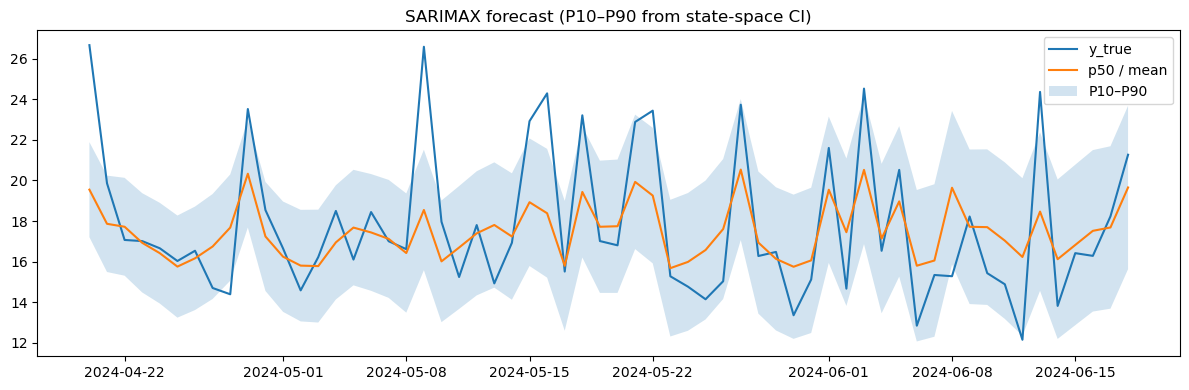


== SARIMAX ==
           pinball_0.1: 0.3806
           pinball_0.5: 0.9932
           pinball_0.9: 0.5879
  coverage_80(P10-P90): 0.800
   mean_width(P10-P90): 6.4907
   WIS_proxy(10/50/90): 6.8293


In [39]:
# --- Convert SARIMAX CI to p10/p50/p90 (approx) ---
# NOTE: statsmodels gives symmetric interval based on Gaussian assumptions;
# conf_int(alpha=0.10) corresponds to central 90% (P05-P95). We asked alpha=0.10 earlier,
# so those bounds are 5% and 95% not 10/90. We'll recompute alpha=0.20 for 10/90.
ci_80 = res.get_forecast(steps=h, exog=test[exog_cols]).conf_int(alpha=0.20)

p50 = mean.values
p10 = ci_80.iloc[:, 0].values
p90 = ci_80.iloc[:, 1].values

# --- Plot ---
plot_forecast_with_interval(
    idx=test.index,
    y_true=test["y"].values,
    p50=p50, p10=p10, p90=p90,
    title="SARIMAX forecast (P10–P90 from state-space CI)"
)

# --- Evaluate on the holdout horizon ---
m_sarimax = evaluate_probabilistic_forecast(test["y"].values, p10, p50, p90, label="SARIMAX")
print_metrics(m_sarimax)

# Store multi-quantile predictions for reliability diagram
fc_obj = res.get_forecast(steps=h, exog=test[exog_cols])
qp = {}
for q in EVAL_QUANTILES:
    if q == 0.5:
        qp[q] = fc_obj.predicted_mean.values
    else:
        alpha = 2 * min(q, 1 - q)
        ci = fc_obj.conf_int(alpha=alpha)
        qp[q] = ci.iloc[:, 0].values if q < 0.5 else ci.iloc[:, 1].values
quantile_preds["SARIMAX"] = qp

In [15]:
# --- Rolling-origin backtest ---
metrics_bt = []
folds = rolling_backtest_indices(n_total=len(df), horizon=h, n_folds=4, min_train=400)

for train_end, test_start, test_end in folds:
    tr = df.iloc[:train_end]
    te = df.iloc[test_start:test_end]

    mod = sm.tsa.SARIMAX(
        tr["y"], exog=tr[exog_cols],
        order=(1,1,1), seasonal_order=(1,0,1,7),
        enforce_stationarity=False, enforce_invertibility=False,
    )
    r = mod.fit(disp=False)
    fc = r.get_forecast(steps=h, exog=te[exog_cols])
    p50 = fc.predicted_mean.values
    ci_80 = fc.conf_int(alpha=0.20)
    p10 = ci_80.iloc[:, 0].values
    p90 = ci_80.iloc[:, 1].values

    metrics_bt.append(evaluate_probabilistic_forecast(te["y"].values, p10, p50, p90, label="SARIMAX"))

bt_avg = aggregate_backtest_metrics(metrics_bt)
print("\nSARIMAX backtest avg metrics:", bt_avg)


SARIMAX backtest avg metrics: {'pinball_0.1': 0.3766175991640963, 'pinball_0.5': 1.0704237417342681, 'pinball_0.9': 0.5679070312477514, 'coverage_80(P10-P90)': 0.7708333333333333, 'mean_width(P10-P90)': 5.898078914889492, 'WIS_proxy(10/50/90)': 6.863470635527775}


**Takeaway**: on the synthetic dataset (seed=7), our SARIMAX model is:

- Slightly under-calibrated (intervals too narrow; 3.6% undercoverage)
- Moderately sharp (reasonably narrow intervals)
- Moderately accurate, but not exceptional (pinball loss)

Overall: decent baseline, but uncertainty is slightly overconfident.

Note that SARIMAX assumes:

- linear dynamics
- Gaussian residuals
- fixed variance structure

Our synthetic process contains:

- nonlinear effects (promo impact, price interactions)
- heteroskedastic noise

SARIMAX cannot fully capture this → slightly miscalibrated uncertainty.

## 2) Industry workhorse: LightGBM quantile regression (multiple quantiles)

We will train one model per quantile (simple, very common), using lag/rolling features + covariates.

In [40]:
def fit_lgb_quantile(q: float):
    params = dict(
        objective="quantile",
        alpha=q,
        learning_rate=0.05,
        num_leaves=63,
        min_data_in_leaf=50,
        feature_fraction=0.9,
        bagging_fraction=0.9,
        bagging_freq=1,
        verbose=-1,
    )
    dtrain = lgb.Dataset(X_train, label=y_train)
    booster = lgb.train(params, dtrain, num_boost_round=2000, valid_sets=[dtrain], callbacks=[lgb.early_stopping(50, verbose=False)])
    return booster

In [41]:
feat_df = make_lag_features(df)
feat_df = feat_df.dropna()

train_f = feat_df.iloc[:-h]
test_f  = feat_df.iloc[-h:]

features = [c for c in train_f.columns if c != "y"]

X_train, y_train = train_f[features], train_f["y"]
X_test, y_test   = test_f[features], test_f["y"]

qs = EVAL_QUANTILES   # train a separate model for each quantile level
models = {q: fit_lgb_quantile(q) for q in qs}

preds = {q: models[q].predict(X_test) for q in qs}
quantile_preds["LightGBM"] = {q: preds[q] for q in qs}

lgb_out = pd.DataFrame({
    "y_true": y_test.values,
    "p10": preds[0.1],
    "p50": preds[0.5],
    "p90": preds[0.9],
}, index=test_f.index)

# quick metrics
print("Pinball(0.1):", pinball_loss(y_test.values, lgb_out["p10"].values, 0.1))
print("Pinball(0.5):", pinball_loss(y_test.values, lgb_out["p50"].values, 0.5))
print("Pinball(0.9):", pinball_loss(y_test.values, lgb_out["p90"].values, 0.9))

# lgb_out.head()

Pinball(0.1): 0.3974096295210048
Pinball(0.5): 0.9768299446138897
Pinball(0.9): 0.6328142341840468


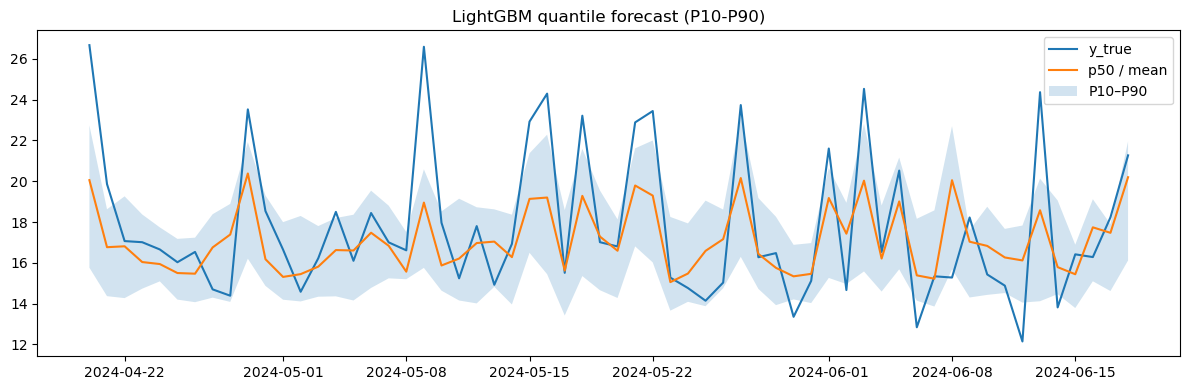


== LightGBM-Quantiles ==
           pinball_0.1: 0.3974
           pinball_0.5: 0.9768
           pinball_0.9: 0.6328
  coverage_80(P10-P90): 0.633
   mean_width(P10-P90): 4.4911
   WIS_proxy(10/50/90): 7.1048


In [42]:
# ── Plot + Evaluate ──
p10 = lgb_out["p10"].values
p50 = lgb_out["p50"].values
p90 = lgb_out["p90"].values

plot_forecast_with_interval(
    idx=lgb_out.index,
    y_true=lgb_out["y_true"].values,
    p50=p50, p10=p10, p90=p90,
    title="LightGBM quantile forecast (P10-P90)"
)

m_lgbm = evaluate_probabilistic_forecast(lgb_out["y_true"].values, p10, p50, p90, label="LightGBM-Quantiles")
print_metrics(m_lgbm)

In [19]:
# ── Rolling-origin backtest ──
metrics_bt = []
folds = rolling_backtest_indices(n_total=len(feat_df), horizon=h, n_folds=5, min_train=400)

for train_end, test_start, test_end in folds:
    tr = feat_df.iloc[:train_end].dropna()
    te = feat_df.iloc[test_start:test_end].dropna()

    Xtr, ytr = tr[features], tr["y"]
    Xte, yte = te[features], te["y"]

    def fit_q(q):
        params = dict(objective="quantile", alpha=q, learning_rate=0.05, num_leaves=63,
                      min_data_in_leaf=50, feature_fraction=0.9, bagging_fraction=0.9,
                      bagging_freq=1, verbose=-1)
        dtr = lgb.Dataset(Xtr, label=ytr)
        return lgb.train(params, dtr, num_boost_round=1500, valid_sets=[dtr],
                         callbacks=[lgb.early_stopping(50, verbose=False)])

    m10, m50, m90 = fit_q(0.1), fit_q(0.5), fit_q(0.9)
    p10 = m10.predict(Xte); p50 = m50.predict(Xte); p90 = m90.predict(Xte)

    metrics_bt.append(evaluate_probabilistic_forecast(yte.values, p10, p50, p90, label="LGBM"))

bt_avg = aggregate_backtest_metrics(metrics_bt)
print("\nLightGBM backtest avg metrics:", bt_avg)


LightGBM backtest avg metrics: {'pinball_0.1': 0.32007114355423927, 'pinball_0.5': 0.801851089428774, 'pinball_0.9': 0.5370605481265238, 'coverage_80(P10-P90)': 0.6266666666666667, 'mean_width(P10-P90)': 3.736816469821761, 'WIS_proxy(10/50/90)': 5.889360637261364}


**Takeaway**: on our synthetic dataset (seed=7), LightGBM is much more accurate (25% lower pinball_0.5) and much sharper (37% narrower interval) than SARIMAX — but severely overconfident (badly miscalibrated). Instead of missing 20% of points, it misses 37% - nearly double.

LightGBM quantile training optimizes:
- "minimize pinball loss"

NOT
- "ensure correct probabilistic calibration".

Adding conformal calibrations on top of our quantile LGBM would address this.

**Production notes**

- This is usually paired with: strong backtesting, covariate availability guarantees, leakage checks, and monitoring for feature drift.
- Quantiles can cross (P90 < P50) unless you enforce monotonicity post-hoc (e.g., isotonic fix) or use joint quantile approaches.

## 3) "Distributional boosting": NGBoost (predict a full distribution)

Instead of quantiles, we fit parameters of a distribution (e.g., Normal) via natural-gradient boosting; very practical when we want a proper probabilistic model with likelihood-based training.

In [45]:
# Use same feature matrix as LightGBM

base = DecisionTreeRegressor(max_depth=3, min_samples_leaf=30, random_state=7)
#base = HistGradientBoostingRegressor(max_depth=6, learning_rate=0.05)
ngb = NGBRegressor(Dist=Normal, Base=base, n_estimators=600, learning_rate=0.03, verbose=False, random_state=7)

ngb.fit(X_train, y_train)

dist = ngb.pred_dist(X_test) 
p10 = dist.ppf(0.1)
p50 = dist.ppf(0.5)
p90 = dist.ppf(0.9)

ngb_out = pd.DataFrame({"y_true": y_test, "p10": p10, "p50": p50, "p90": p90}, index=test_f.index)
#ngb_out.head()

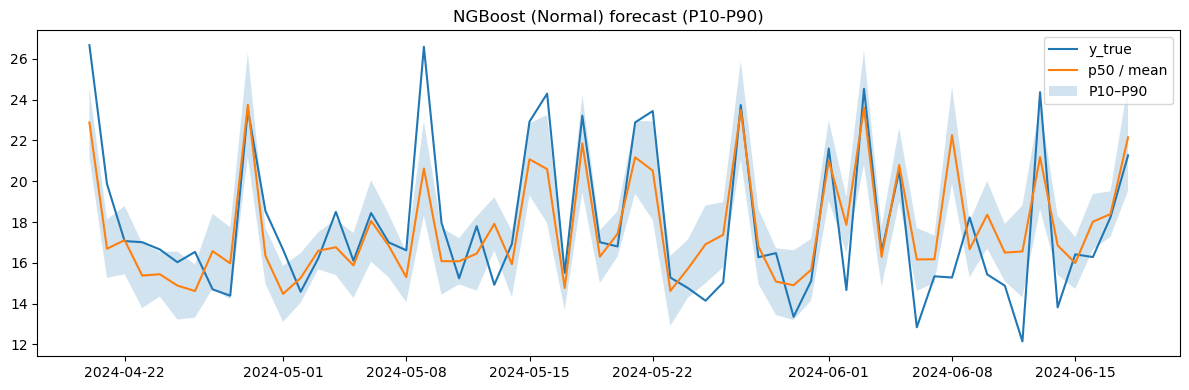


== NGBoost-Normal ==
           pinball_0.1: 0.4642
           pinball_0.5: 0.8399
           pinball_0.9: 0.3746
  coverage_80(P10-P90): 0.533
   mean_width(P10-P90): 3.3681
   WIS_proxy(10/50/90): 5.8736


In [46]:
# ── Plot + Evaluate ──
p10 = ngb_out["p10"].values
p50 = ngb_out["p50"].values
p90 = ngb_out["p90"].values

plot_forecast_with_interval(
    idx=ngb_out.index,
    y_true=ngb_out["y_true"].values,
    p50=p50, p10=p10, p90=p90,
    title="NGBoost (Normal) forecast (P10-P90)"
)

m_ngboost = evaluate_probabilistic_forecast(ngb_out["y_true"].values, p10, p50, p90, label="NGBoost-Normal")
print_metrics(m_ngboost)

# Store multi-quantile predictions (before backtest overwrites `dist`)
quantile_preds["NGBoost"] = {q: dist.ppf(q) for q in EVAL_QUANTILES}

In [26]:
# ── Rolling-origin backtest ──
metrics_bt = []
folds = rolling_backtest_indices(n_total=len(feat_df), horizon=h, n_folds=5, min_train=400)

for train_end, test_start, test_end in folds:
    tr = feat_df.iloc[:train_end].dropna()
    te = feat_df.iloc[test_start:test_end].dropna()

    Xtr, ytr = tr[features], tr["y"]
    Xte, yte = te[features], te["y"]

    base = DecisionTreeRegressor(max_depth=3, min_samples_leaf=30, random_state=7)
    ngb = NGBRegressor(Dist=Normal, Base=base, n_estimators=600, learning_rate=0.03, verbose=False, random_state=7)
    ngb.fit(Xtr, ytr)

    dist = ngb.pred_dist(Xte)
    p10 = dist.ppf(0.1); p50 = dist.ppf(0.5); p90 = dist.ppf(0.9)

    metrics_bt.append(evaluate_probabilistic_forecast(yte.values, p10, p50, p90, label="NGBoost"))

bt_avg = aggregate_backtest_metrics(metrics_bt)
print("\nNGBoost backtest avg metrics:", bt_avg)


NGBoost backtest avg metrics: {'pinball_0.1': 0.3327186896535302, 'pinball_0.5': 0.741956141190667, 'pinball_0.9': 0.48284799827029845, 'coverage_80(P10-P90)': 0.5733333333333334, 'mean_width(P10-P90)': 2.7225998449132396, 'WIS_proxy(10/50/90)': 5.561745722000478}


**Takeaways**: 

- On our synthetic dataset, NGB gave us the best accuracy so far, sharpest intervals (54% narrower than SARIMAX, 27% narrower than LightGBM), but worst calibration (severely broken - missing 43% of the true values instead of the exp. 20%).
- WIS is the best so far, but it's misleading without calibration. Coverage is the critical metric here.
- In order to fix NGB, we would add conformal calibrations on top.

**Production notes**

- Here we get a coherent distribution (no quantile crossing).
- But our distributional assumption (Normal, Student-t, etc.) matters; mis-specification can hurt calibration.

## 4) Calibration layer: Split-conformal prediction intervals on top of any model

Conformal prediction is a huge deal operationally because it gives **distribution-free coverage guarantees** and works with any regressor. The simplest and most robust variant — and the one most commonly used in production — is **split-conformal prediction**:

1. **Fit** a point model on a "fit" subset of the training data.
2. **Calibrate**: compute the model's signed residuals on a held-out calibration window (data the model never saw).
3. **Predict**: shift the point forecast by quantiles of those calibration residuals to get prediction intervals.

Coverage guarantee: under exchangeability of calibration and test residuals (approximately true for stationary series when the calibration window is recent), the interval covers at the nominal rate.

In [47]:
# ── Split-conformal prediction ──────────────────────────────────────────
# Reserve the last portion of training data as a calibration set.
# The model never sees this data during fitting → residuals are "honest".
cal_frac = 0.15  # 15% of training data for calibration
cal_size = int(cal_frac * len(X_train))
X_fit, y_fit = X_train.iloc[:-cal_size], y_train.iloc[:-cal_size]
X_cal, y_cal = X_train.iloc[-cal_size:], y_train.iloc[-cal_size:]

print(f"Split-conformal setup: fit={len(X_fit)}, cal={cal_size}, test={len(X_test)}")

# 1. Fit a single strong model on the fit portion
conf_model = HistGradientBoostingRegressor(max_depth=6, learning_rate=0.05, random_state=7)
conf_model.fit(X_fit, y_fit)

# 2. Compute signed residuals on the calibration window
#    Signed residuals preserve asymmetry: if the model tends to overpredict,
#    the lower quantile of residuals will be more negative → interval shifts down.
cal_residuals = y_cal.values - conf_model.predict(X_cal)

print(f"Calibration residuals: mean={cal_residuals.mean():.3f}, "
      f"std={cal_residuals.std():.3f}, "
      f"range=[{cal_residuals.min():.2f}, {cal_residuals.max():.2f}]")

# 3. Predict on test set
y_pred = conf_model.predict(X_test)

# For any quantile q: interval bound = y_pred + quantile(cal_residuals, q)
def conformal_quantile(y_pred, cal_residuals, q):
    """Shift point forecast by the q-th quantile of calibration residuals."""
    return y_pred + np.quantile(cal_residuals, q)

p10 = conformal_quantile(y_pred, cal_residuals, 0.10)
p50 = y_pred
p90 = conformal_quantile(y_pred, cal_residuals, 0.90)

conf_out = pd.DataFrame({
    "y_true": y_test, "y_pred": y_pred, "p10": p10, "p90": p90
}, index=test_f.index)

# Quick sanity: empirical 80% coverage (should be ≈ 0.80)
cov_80 = np.mean((y_test >= p10) & (y_test <= p90))
print(f"\nEmpirical 80% coverage (P10–P90): {cov_80:.3f}")

Split-conformal setup: fit=691, cal=121, test=60
Calibration residuals: mean=1.404, std=2.406, range=[-5.70, 9.64]

Empirical 80% coverage (P10–P90): 0.767


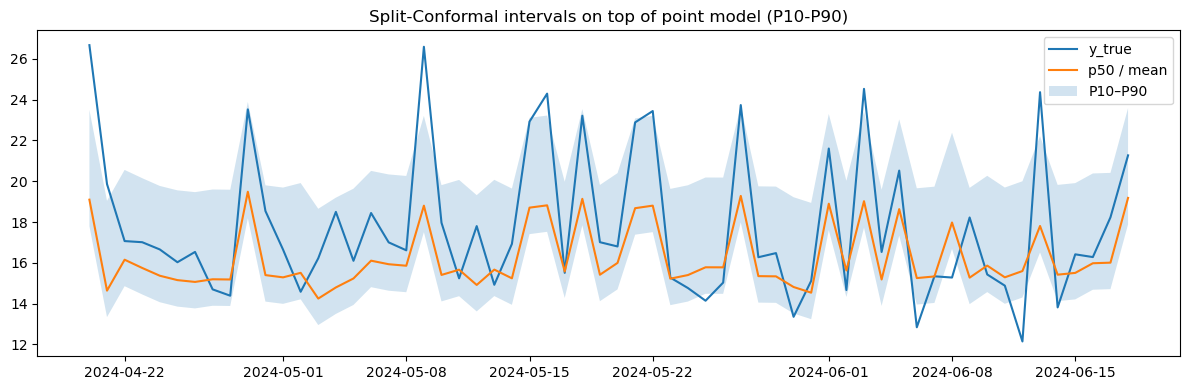


== Conformal ==
           pinball_0.1: 0.3739
           pinball_0.5: 1.0951
           pinball_0.9: 0.4881
  coverage_80(P10-P90): 0.767
   mean_width(P10-P90): 5.7034
   WIS_proxy(10/50/90): 6.4999


In [48]:
# ── Plot + Evaluate ──
plot_forecast_with_interval(
    idx=test_f.index,
    y_true=y_test.values,
    p50=p50, p10=p10, p90=p90,
    title="Split-Conformal intervals on top of point model (P10-P90)"
)

m_conformal = evaluate_probabilistic_forecast(y_test.values, p10, p50, p90, label="Conformal")
print_metrics(m_conformal)

# Store multi-quantile predictions for reliability / PIT / CRPS
quantile_preds["Conformal"] = {
    q: conformal_quantile(y_pred, cal_residuals, q) for q in EVAL_QUANTILES
}

In [33]:
# ── Rolling-origin backtest ──
metrics_bt = []
folds = rolling_backtest_indices(n_total=len(feat_df), horizon=h, n_folds=5, min_train=400)

for train_end, test_start, test_end in folds:
    tr = feat_df.iloc[:train_end].dropna()
    te = feat_df.iloc[test_start:test_end].dropna()

    Xtr, ytr = tr[features], tr["y"]
    Xte, yte = te[features], te["y"]

    cal_n = int(0.15 * len(Xtr))
    Xfit, yfit = Xtr.iloc[:-cal_n], ytr.iloc[:-cal_n]
    Xcal, ycal = Xtr.iloc[-cal_n:], ytr.iloc[-cal_n:]

    model = HistGradientBoostingRegressor(max_depth=6, learning_rate=0.05, random_state=7)
    model.fit(Xfit, yfit)

    cal_res = ycal.values - model.predict(Xcal)
    pred = model.predict(Xte)

    p10 = pred + np.quantile(cal_res, 0.10)
    p50 = pred
    p90 = pred + np.quantile(cal_res, 0.90)

    metrics_bt.append(evaluate_probabilistic_forecast(yte.values, p10, p50, p90, label="Conformal"))

bt_avg = aggregate_backtest_metrics(metrics_bt)
print("\nConformal backtest avg metrics:", bt_avg)


Conformal backtest avg metrics: {'pinball_0.1': 0.32278523051298, 'pinball_0.5': 0.8540739275619451, 'pinball_0.9': 0.46729311375913624, 'coverage_80(P10-P90)': 0.76, 'mean_width(P10-P90)': 4.6971020108254535, 'WIS_proxy(10/50/90)': 5.658539576484471}


**Takeaway**: 
- Across all models so far (on the synthetic dataset), we're seeing a typical production pattern: flexible ML models (LightGBM, NGBoost, HistGradientBoostingRegressor) achieve substantially better point accuracy and much sharper prediction intervals than SARIMAX, but their raw probabilistic outputs are severely overconfident (coverage ~0.57–0.63 instead of the target 0.80), making their uncertainty estimates unreliable without correction. 
- Applying split conformal calibration on top of HistGradientBoostingRegressor successfully fixed most of this miscalibration (coverage improves to ~0.76) while preserving most of the gains in accuracy and sharpness (interval width ~4.7 vs 5.9 for SARIMAX and much better pinball/WIS).

**Production notes**

- Split-conformal is the simplest way to stop shipping overconfident intervals — no library needed, ~20 lines.
- The `cal_frac` parameter (here 15%) controls the bias-variance trade-off: a larger calibration set gives more stable quantile estimates but leaves less data for model training.
- For non-stationary series, use a **sliding calibration window** (only recent residuals) instead of a fixed split. This adapts to distribution shift.
- For **online/streaming** settings where you need intervals that update as new observations arrive, look into **Adaptive Conformal Inference (ACI)** or **EnbPI** — the library-based approaches (e.g. MAPIE) that add complexity but handle temporal drift automatically.

## 5) Deep probabilistic global model: DeepAR in GluonTS

DeepAR is a canonical probabilistic deep model for forecasting and is designed to train across many series. GluonTS focuses on probabilistic forecasting.

Below we try a minimal example for our single series (the real payoff is multiple series).

In [59]:
# ── Covariates for GluonTS ──────────────────────────────────────────────
train_covariates = np.stack([train["promo"].values, train["price"].values])   # (2, len_train)
full_covariates  = np.stack([df["promo"].values, df["price"].values])         # (2, len_df)

# GluonTS expects: start timestamp + target array + optional covariates
training_data = ListDataset(
    [{"start": train.index[0],
      "target": train["y"].values,
      "feat_dynamic_real": train_covariates}],
    freq="D",
)

# DeepAR probabilistic model
# Key settings:
#   • num_feat_dynamic_real=2 — MUST match # user covariates (promo, price);
#     without this GluonTS silently *deletes* feat_dynamic_real from the pipeline!
#   • context_length=180: captures ≈6 months of patterns (weekly + partial yearly)
#   • num_batches_per_epoch=20: prevents overfitting on a single 840-point series
#     (default 50 × 32 = 1 600 samples/epoch; each window seen ~260× over 100 epochs)
estimator = DeepAREstimator(
    freq="D",
    prediction_length=h,
    context_length=180,
    num_feat_dynamic_real=2,       # ← critical: tell GluonTS we have 2 covariates
    num_layers=2,
    hidden_size=40,
    distr_output=StudentTOutput(),  # heavier tails match our DGP (Student-t noise)
    batch_size=32,
    num_batches_per_epoch=20,      # ← tame overfitting on single series
    lr=1e-3,
    trainer_kwargs=dict(max_epochs=100),
)

predictor = estimator.train(training_data)

# Make forecast — test entry contains the FULL series so GluonTS can use
# the last `context_length` values as context and forecast `prediction_length`.
# Covariates must cover the full span (including the forecast horizon).
test_data = ListDataset(
    [{"start": train.index[0],
      "target": df["y"].values,
      "feat_dynamic_real": full_covariates}],
    freq="D",
)

forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_data, predictor=predictor, num_samples=300   # more samples → smoother quantiles
)

forecast = next(forecast_it)

# quantiles
p10 = forecast.quantile(0.1)
p50 = forecast.quantile(0.5)
p90 = forecast.quantile(0.9)

deepar_out = pd.DataFrame(
    {"p10": p10, "p50": p50, "p90": p90, "y_true": test["y"].values},
    index=test.index
)
deepar_out.head()

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.

  | Name  | Type        | Params | Mode  | FLOPs | In sizes                                                         | Out sizes   
----------------------------------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 26.2 K | train | 1.5 M | [[1, 1], [1, 1], [1, 1272, 6], [1, 1272], [1, 1272], [1, 60, 6]] | [1, 100, 60]
----------------------------------------------------------------------------------------------------------------------------------------
26.2 K    Trainable params
0         Non-trainable params
26.2 K    Total params
0.105     Total estimated model params size (MB)
11        Modules in tra

Epoch 0: |          | 20/? [00:00<00:00, 22.36it/s, v_num=17, train_loss=3.150]

Epoch 0, global step 20: 'train_loss' reached 3.15318 (best 3.15318), saving model to '/Users/francescoamato/dev/ts-prob-forecast-playground/lightning_logs/version_17/checkpoints/epoch=0-step=20.ckpt' as top 1


Epoch 1: |          | 20/? [00:00<00:00, 20.50it/s, v_num=17, train_loss=2.340]

Epoch 1, global step 40: 'train_loss' reached 2.34465 (best 2.34465), saving model to '/Users/francescoamato/dev/ts-prob-forecast-playground/lightning_logs/version_17/checkpoints/epoch=1-step=40.ckpt' as top 1


Epoch 2: |          | 20/? [00:00<00:00, 23.53it/s, v_num=17, train_loss=2.070]

Epoch 2, global step 60: 'train_loss' reached 2.06613 (best 2.06613), saving model to '/Users/francescoamato/dev/ts-prob-forecast-playground/lightning_logs/version_17/checkpoints/epoch=2-step=60.ckpt' as top 1


Epoch 3: |          | 20/? [00:00<00:00, 22.66it/s, v_num=17, train_loss=2.010]

Epoch 3, global step 80: 'train_loss' reached 2.00808 (best 2.00808), saving model to '/Users/francescoamato/dev/ts-prob-forecast-playground/lightning_logs/version_17/checkpoints/epoch=3-step=80.ckpt' as top 1


Epoch 4: |          | 20/? [00:00<00:00, 23.48it/s, v_num=17, train_loss=1.970]

Epoch 4, global step 100: 'train_loss' reached 1.96907 (best 1.96907), saving model to '/Users/francescoamato/dev/ts-prob-forecast-playground/lightning_logs/version_17/checkpoints/epoch=4-step=100.ckpt' as top 1


Epoch 5: |          | 20/? [00:00<00:00, 23.08it/s, v_num=17, train_loss=1.940]

Epoch 5, global step 120: 'train_loss' reached 1.94310 (best 1.94310), saving model to '/Users/francescoamato/dev/ts-prob-forecast-playground/lightning_logs/version_17/checkpoints/epoch=5-step=120.ckpt' as top 1


Epoch 6: |          | 20/? [00:00<00:00, 23.01it/s, v_num=17, train_loss=1.910]

Epoch 6, global step 140: 'train_loss' reached 1.90544 (best 1.90544), saving model to '/Users/francescoamato/dev/ts-prob-forecast-playground/lightning_logs/version_17/checkpoints/epoch=6-step=140.ckpt' as top 1


Epoch 7: |          | 20/? [00:00<00:00, 23.14it/s, v_num=17, train_loss=1.790]

Epoch 7, global step 160: 'train_loss' reached 1.78950 (best 1.78950), saving model to '/Users/francescoamato/dev/ts-prob-forecast-playground/lightning_logs/version_17/checkpoints/epoch=7-step=160.ckpt' as top 1


Epoch 8: |          | 20/? [00:01<00:00, 19.62it/s, v_num=17, train_loss=1.760]

Epoch 8, global step 180: 'train_loss' reached 1.75772 (best 1.75772), saving model to '/Users/francescoamato/dev/ts-prob-forecast-playground/lightning_logs/version_17/checkpoints/epoch=8-step=180.ckpt' as top 1


Epoch 9: |          | 20/? [00:00<00:00, 24.90it/s, v_num=17, train_loss=1.720]

Epoch 9, global step 200: 'train_loss' reached 1.71759 (best 1.71759), saving model to '/Users/francescoamato/dev/ts-prob-forecast-playground/lightning_logs/version_17/checkpoints/epoch=9-step=200.ckpt' as top 1


Epoch 10: |          | 20/? [00:00<00:00, 23.45it/s, v_num=17, train_loss=1.670]

Epoch 10, global step 220: 'train_loss' reached 1.67288 (best 1.67288), saving model to '/Users/francescoamato/dev/ts-prob-forecast-playground/lightning_logs/version_17/checkpoints/epoch=10-step=220.ckpt' as top 1


Epoch 11: |          | 20/? [00:00<00:00, 24.54it/s, v_num=17, train_loss=1.660]

Epoch 11, global step 240: 'train_loss' reached 1.65571 (best 1.65571), saving model to '/Users/francescoamato/dev/ts-prob-forecast-playground/lightning_logs/version_17/checkpoints/epoch=11-step=240.ckpt' as top 1


Epoch 12: |          | 20/? [00:00<00:00, 25.05it/s, v_num=17, train_loss=1.660]

Epoch 12, global step 260: 'train_loss' was not in top 1


Epoch 13: |          | 20/? [00:00<00:00, 24.13it/s, v_num=17, train_loss=1.600]

Epoch 13, global step 280: 'train_loss' reached 1.59860 (best 1.59860), saving model to '/Users/francescoamato/dev/ts-prob-forecast-playground/lightning_logs/version_17/checkpoints/epoch=13-step=280.ckpt' as top 1


Epoch 14: |          | 20/? [00:00<00:00, 23.18it/s, v_num=17, train_loss=1.610]

Epoch 14, global step 300: 'train_loss' was not in top 1


Epoch 15: |          | 20/? [00:01<00:00, 19.19it/s, v_num=17, train_loss=1.630]

Epoch 15, global step 320: 'train_loss' was not in top 1


Epoch 16: |          | 20/? [00:00<00:00, 23.88it/s, v_num=17, train_loss=1.580]

Epoch 16, global step 340: 'train_loss' reached 1.57785 (best 1.57785), saving model to '/Users/francescoamato/dev/ts-prob-forecast-playground/lightning_logs/version_17/checkpoints/epoch=16-step=340.ckpt' as top 1


Epoch 17: |          | 20/? [00:00<00:00, 23.95it/s, v_num=17, train_loss=1.580]

Epoch 17, global step 360: 'train_loss' was not in top 1


Epoch 18: |          | 20/? [00:00<00:00, 23.87it/s, v_num=17, train_loss=1.620]

Epoch 18, global step 380: 'train_loss' was not in top 1


Epoch 19: |          | 20/? [00:00<00:00, 22.68it/s, v_num=17, train_loss=1.560]

Epoch 19, global step 400: 'train_loss' reached 1.56391 (best 1.56391), saving model to '/Users/francescoamato/dev/ts-prob-forecast-playground/lightning_logs/version_17/checkpoints/epoch=19-step=400.ckpt' as top 1


Epoch 20: |          | 20/? [00:00<00:00, 24.32it/s, v_num=17, train_loss=1.580]

Epoch 20, global step 420: 'train_loss' was not in top 1


Epoch 21: |          | 20/? [00:00<00:00, 23.74it/s, v_num=17, train_loss=1.570]

Epoch 21, global step 440: 'train_loss' was not in top 1


Epoch 22: |          | 20/? [00:00<00:00, 23.14it/s, v_num=17, train_loss=1.540]

Epoch 22, global step 460: 'train_loss' reached 1.54230 (best 1.54230), saving model to '/Users/francescoamato/dev/ts-prob-forecast-playground/lightning_logs/version_17/checkpoints/epoch=22-step=460.ckpt' as top 1


Epoch 23: |          | 20/? [00:00<00:00, 20.59it/s, v_num=17, train_loss=1.530]

Epoch 23, global step 480: 'train_loss' reached 1.52788 (best 1.52788), saving model to '/Users/francescoamato/dev/ts-prob-forecast-playground/lightning_logs/version_17/checkpoints/epoch=23-step=480.ckpt' as top 1


Epoch 24: |          | 20/? [00:00<00:00, 22.66it/s, v_num=17, train_loss=1.530]

Epoch 24, global step 500: 'train_loss' was not in top 1


Epoch 25: |          | 20/? [00:00<00:00, 23.89it/s, v_num=17, train_loss=1.540]

Epoch 25, global step 520: 'train_loss' was not in top 1


Epoch 26: |          | 20/? [00:00<00:00, 23.73it/s, v_num=17, train_loss=1.520]

Epoch 26, global step 540: 'train_loss' reached 1.51677 (best 1.51677), saving model to '/Users/francescoamato/dev/ts-prob-forecast-playground/lightning_logs/version_17/checkpoints/epoch=26-step=540.ckpt' as top 1


Epoch 27: |          | 20/? [00:00<00:00, 23.21it/s, v_num=17, train_loss=1.520]

Epoch 27, global step 560: 'train_loss' was not in top 1


Epoch 28: |          | 20/? [00:00<00:00, 20.63it/s, v_num=17, train_loss=1.510]

Epoch 28, global step 580: 'train_loss' reached 1.51465 (best 1.51465), saving model to '/Users/francescoamato/dev/ts-prob-forecast-playground/lightning_logs/version_17/checkpoints/epoch=28-step=580.ckpt' as top 1


Epoch 29: |          | 20/? [00:00<00:00, 22.94it/s, v_num=17, train_loss=1.500]

Epoch 29, global step 600: 'train_loss' reached 1.49830 (best 1.49830), saving model to '/Users/francescoamato/dev/ts-prob-forecast-playground/lightning_logs/version_17/checkpoints/epoch=29-step=600.ckpt' as top 1


Epoch 30: |          | 20/? [00:00<00:00, 24.72it/s, v_num=17, train_loss=1.490]

Epoch 30, global step 620: 'train_loss' reached 1.49207 (best 1.49207), saving model to '/Users/francescoamato/dev/ts-prob-forecast-playground/lightning_logs/version_17/checkpoints/epoch=30-step=620.ckpt' as top 1


Epoch 31: |          | 20/? [00:00<00:00, 20.91it/s, v_num=17, train_loss=1.500]

Epoch 31, global step 640: 'train_loss' was not in top 1


Epoch 32: |          | 20/? [00:00<00:00, 22.86it/s, v_num=17, train_loss=1.500]

Epoch 32, global step 660: 'train_loss' was not in top 1


Epoch 33: |          | 20/? [00:00<00:00, 22.93it/s, v_num=17, train_loss=1.490]

Epoch 33, global step 680: 'train_loss' was not in top 1


Epoch 34: |          | 20/? [00:00<00:00, 22.69it/s, v_num=17, train_loss=1.480]

Epoch 34, global step 700: 'train_loss' reached 1.48281 (best 1.48281), saving model to '/Users/francescoamato/dev/ts-prob-forecast-playground/lightning_logs/version_17/checkpoints/epoch=34-step=700.ckpt' as top 1


Epoch 35: |          | 20/? [00:00<00:00, 24.42it/s, v_num=17, train_loss=1.480]

Epoch 35, global step 720: 'train_loss' reached 1.47677 (best 1.47677), saving model to '/Users/francescoamato/dev/ts-prob-forecast-playground/lightning_logs/version_17/checkpoints/epoch=35-step=720.ckpt' as top 1


Epoch 36: |          | 20/? [00:00<00:00, 24.30it/s, v_num=17, train_loss=1.440]

Epoch 36, global step 740: 'train_loss' reached 1.43664 (best 1.43664), saving model to '/Users/francescoamato/dev/ts-prob-forecast-playground/lightning_logs/version_17/checkpoints/epoch=36-step=740.ckpt' as top 1


Epoch 37: |          | 20/? [00:00<00:00, 22.58it/s, v_num=17, train_loss=1.430]

Epoch 37, global step 760: 'train_loss' reached 1.43404 (best 1.43404), saving model to '/Users/francescoamato/dev/ts-prob-forecast-playground/lightning_logs/version_17/checkpoints/epoch=37-step=760.ckpt' as top 1


Epoch 38: |          | 20/? [00:01<00:00, 17.67it/s, v_num=17, train_loss=1.410]

Epoch 38, global step 780: 'train_loss' reached 1.41499 (best 1.41499), saving model to '/Users/francescoamato/dev/ts-prob-forecast-playground/lightning_logs/version_17/checkpoints/epoch=38-step=780.ckpt' as top 1


Epoch 39: |          | 20/? [00:00<00:00, 24.86it/s, v_num=17, train_loss=1.440]

Epoch 39, global step 800: 'train_loss' was not in top 1


Epoch 40: |          | 20/? [00:00<00:00, 22.23it/s, v_num=17, train_loss=1.430]

Epoch 40, global step 820: 'train_loss' was not in top 1


Epoch 41: |          | 20/? [00:00<00:00, 23.64it/s, v_num=17, train_loss=1.430]

Epoch 41, global step 840: 'train_loss' was not in top 1


Epoch 42: |          | 20/? [00:00<00:00, 24.60it/s, v_num=17, train_loss=1.380]

Epoch 42, global step 860: 'train_loss' reached 1.38441 (best 1.38441), saving model to '/Users/francescoamato/dev/ts-prob-forecast-playground/lightning_logs/version_17/checkpoints/epoch=42-step=860.ckpt' as top 1


Epoch 43: |          | 20/? [00:00<00:00, 24.63it/s, v_num=17, train_loss=1.400]

Epoch 43, global step 880: 'train_loss' was not in top 1


Epoch 44: |          | 20/? [00:00<00:00, 22.79it/s, v_num=17, train_loss=1.420]

Epoch 44, global step 900: 'train_loss' was not in top 1


Epoch 45: |          | 20/? [00:00<00:00, 23.97it/s, v_num=17, train_loss=1.380]

Epoch 45, global step 920: 'train_loss' reached 1.37802 (best 1.37802), saving model to '/Users/francescoamato/dev/ts-prob-forecast-playground/lightning_logs/version_17/checkpoints/epoch=45-step=920.ckpt' as top 1


Epoch 46: |          | 20/? [00:01<00:00, 19.97it/s, v_num=17, train_loss=1.380]

Epoch 46, global step 940: 'train_loss' was not in top 1


Epoch 47: |          | 20/? [00:00<00:00, 23.56it/s, v_num=17, train_loss=1.420]

Epoch 47, global step 960: 'train_loss' was not in top 1


Epoch 48: |          | 20/? [00:00<00:00, 24.99it/s, v_num=17, train_loss=1.360]

Epoch 48, global step 980: 'train_loss' reached 1.35924 (best 1.35924), saving model to '/Users/francescoamato/dev/ts-prob-forecast-playground/lightning_logs/version_17/checkpoints/epoch=48-step=980.ckpt' as top 1


Epoch 49: |          | 20/? [00:00<00:00, 23.66it/s, v_num=17, train_loss=1.360]

Epoch 49, global step 1000: 'train_loss' was not in top 1


Epoch 50: |          | 20/? [00:00<00:00, 23.81it/s, v_num=17, train_loss=1.370]

Epoch 50, global step 1020: 'train_loss' was not in top 1


Epoch 51: |          | 20/? [00:00<00:00, 25.21it/s, v_num=17, train_loss=1.360]

Epoch 51, global step 1040: 'train_loss' was not in top 1


Epoch 52: |          | 20/? [00:00<00:00, 24.35it/s, v_num=17, train_loss=1.350]

Epoch 52, global step 1060: 'train_loss' reached 1.35040 (best 1.35040), saving model to '/Users/francescoamato/dev/ts-prob-forecast-playground/lightning_logs/version_17/checkpoints/epoch=52-step=1060.ckpt' as top 1


Epoch 53: |          | 20/? [00:00<00:00, 20.83it/s, v_num=17, train_loss=1.360]

Epoch 53, global step 1080: 'train_loss' was not in top 1


Epoch 54: |          | 20/? [00:00<00:00, 23.23it/s, v_num=17, train_loss=1.340]

Epoch 54, global step 1100: 'train_loss' reached 1.34033 (best 1.34033), saving model to '/Users/francescoamato/dev/ts-prob-forecast-playground/lightning_logs/version_17/checkpoints/epoch=54-step=1100.ckpt' as top 1


Epoch 55: |          | 20/? [00:00<00:00, 24.63it/s, v_num=17, train_loss=1.350]

Epoch 55, global step 1120: 'train_loss' was not in top 1


Epoch 56: |          | 20/? [00:00<00:00, 24.02it/s, v_num=17, train_loss=1.330]

Epoch 56, global step 1140: 'train_loss' reached 1.33410 (best 1.33410), saving model to '/Users/francescoamato/dev/ts-prob-forecast-playground/lightning_logs/version_17/checkpoints/epoch=56-step=1140.ckpt' as top 1


Epoch 57: |          | 20/? [00:00<00:00, 24.92it/s, v_num=17, train_loss=1.320]

Epoch 57, global step 1160: 'train_loss' reached 1.31810 (best 1.31810), saving model to '/Users/francescoamato/dev/ts-prob-forecast-playground/lightning_logs/version_17/checkpoints/epoch=57-step=1160.ckpt' as top 1


Epoch 58: |          | 20/? [00:00<00:00, 23.76it/s, v_num=17, train_loss=1.340]

Epoch 58, global step 1180: 'train_loss' was not in top 1


Epoch 59: |          | 20/? [00:00<00:00, 24.51it/s, v_num=17, train_loss=1.330]

Epoch 59, global step 1200: 'train_loss' was not in top 1


Epoch 60: |          | 20/? [00:00<00:00, 22.82it/s, v_num=17, train_loss=1.340]

Epoch 60, global step 1220: 'train_loss' was not in top 1


Epoch 61: |          | 20/? [00:00<00:00, 21.54it/s, v_num=17, train_loss=1.330]

Epoch 61, global step 1240: 'train_loss' was not in top 1


Epoch 62: |          | 20/? [00:00<00:00, 24.26it/s, v_num=17, train_loss=1.320]

Epoch 62, global step 1260: 'train_loss' was not in top 1


Epoch 63: |          | 20/? [00:00<00:00, 22.97it/s, v_num=17, train_loss=1.310]

Epoch 63, global step 1280: 'train_loss' reached 1.30948 (best 1.30948), saving model to '/Users/francescoamato/dev/ts-prob-forecast-playground/lightning_logs/version_17/checkpoints/epoch=63-step=1280.ckpt' as top 1


Epoch 64: |          | 20/? [00:00<00:00, 21.69it/s, v_num=17, train_loss=1.310]

Epoch 64, global step 1300: 'train_loss' reached 1.30515 (best 1.30515), saving model to '/Users/francescoamato/dev/ts-prob-forecast-playground/lightning_logs/version_17/checkpoints/epoch=64-step=1300.ckpt' as top 1


Epoch 65: |          | 20/? [00:00<00:00, 23.91it/s, v_num=17, train_loss=1.300]

Epoch 65, global step 1320: 'train_loss' reached 1.29719 (best 1.29719), saving model to '/Users/francescoamato/dev/ts-prob-forecast-playground/lightning_logs/version_17/checkpoints/epoch=65-step=1320.ckpt' as top 1


Epoch 66: |          | 20/? [00:00<00:00, 23.66it/s, v_num=17, train_loss=1.310]

Epoch 66, global step 1340: 'train_loss' was not in top 1


Epoch 67: |          | 20/? [00:00<00:00, 23.57it/s, v_num=17, train_loss=1.290]

Epoch 67, global step 1360: 'train_loss' reached 1.29281 (best 1.29281), saving model to '/Users/francescoamato/dev/ts-prob-forecast-playground/lightning_logs/version_17/checkpoints/epoch=67-step=1360.ckpt' as top 1


Epoch 68: |          | 20/? [00:00<00:00, 20.85it/s, v_num=17, train_loss=1.300]

Epoch 68, global step 1380: 'train_loss' was not in top 1


Epoch 69: |          | 20/? [00:00<00:00, 24.95it/s, v_num=17, train_loss=1.300]

Epoch 69, global step 1400: 'train_loss' was not in top 1


Epoch 70: |          | 20/? [00:00<00:00, 23.87it/s, v_num=17, train_loss=1.300]

Epoch 70, global step 1420: 'train_loss' was not in top 1


Epoch 71: |          | 20/? [00:00<00:00, 23.90it/s, v_num=17, train_loss=1.290]

Epoch 71, global step 1440: 'train_loss' reached 1.29177 (best 1.29177), saving model to '/Users/francescoamato/dev/ts-prob-forecast-playground/lightning_logs/version_17/checkpoints/epoch=71-step=1440.ckpt' as top 1


Epoch 72: |          | 20/? [00:00<00:00, 23.26it/s, v_num=17, train_loss=1.270]

Epoch 72, global step 1460: 'train_loss' reached 1.27352 (best 1.27352), saving model to '/Users/francescoamato/dev/ts-prob-forecast-playground/lightning_logs/version_17/checkpoints/epoch=72-step=1460.ckpt' as top 1


Epoch 73: |          | 20/? [00:00<00:00, 22.57it/s, v_num=17, train_loss=1.240]

Epoch 73, global step 1480: 'train_loss' reached 1.24249 (best 1.24249), saving model to '/Users/francescoamato/dev/ts-prob-forecast-playground/lightning_logs/version_17/checkpoints/epoch=73-step=1480.ckpt' as top 1


Epoch 74: |          | 20/? [00:00<00:00, 24.23it/s, v_num=17, train_loss=1.280]

Epoch 74, global step 1500: 'train_loss' was not in top 1


Epoch 75: |          | 20/? [00:01<00:00, 19.99it/s, v_num=17, train_loss=1.270]

Epoch 75, global step 1520: 'train_loss' was not in top 1


Epoch 76: |          | 20/? [00:00<00:00, 24.28it/s, v_num=17, train_loss=1.270]

Epoch 76, global step 1540: 'train_loss' was not in top 1


Epoch 77: |          | 20/? [00:00<00:00, 24.11it/s, v_num=17, train_loss=1.250]

Epoch 77, global step 1560: 'train_loss' was not in top 1


Epoch 78: |          | 20/? [00:00<00:00, 23.23it/s, v_num=17, train_loss=1.250]

Epoch 78, global step 1580: 'train_loss' was not in top 1


Epoch 79: |          | 20/? [00:00<00:00, 24.17it/s, v_num=17, train_loss=1.230]

Epoch 79, global step 1600: 'train_loss' reached 1.22728 (best 1.22728), saving model to '/Users/francescoamato/dev/ts-prob-forecast-playground/lightning_logs/version_17/checkpoints/epoch=79-step=1600.ckpt' as top 1


Epoch 80: |          | 20/? [00:00<00:00, 22.82it/s, v_num=17, train_loss=1.230]

Epoch 80, global step 1620: 'train_loss' was not in top 1


Epoch 81: |          | 20/? [00:00<00:00, 23.27it/s, v_num=17, train_loss=1.230]

Epoch 81, global step 1640: 'train_loss' was not in top 1


Epoch 82: |          | 20/? [00:00<00:00, 25.54it/s, v_num=17, train_loss=1.250]

Epoch 82, global step 1660: 'train_loss' was not in top 1


Epoch 83: |          | 20/? [00:00<00:00, 20.36it/s, v_num=17, train_loss=1.260]

Epoch 83, global step 1680: 'train_loss' was not in top 1


Epoch 84: |          | 20/? [00:00<00:00, 23.12it/s, v_num=17, train_loss=1.190]

Epoch 84, global step 1700: 'train_loss' reached 1.19263 (best 1.19263), saving model to '/Users/francescoamato/dev/ts-prob-forecast-playground/lightning_logs/version_17/checkpoints/epoch=84-step=1700.ckpt' as top 1


Epoch 85: |          | 20/? [00:00<00:00, 24.21it/s, v_num=17, train_loss=1.240]

Epoch 85, global step 1720: 'train_loss' was not in top 1


Epoch 86: |          | 20/? [00:00<00:00, 23.56it/s, v_num=17, train_loss=1.220]

Epoch 86, global step 1740: 'train_loss' was not in top 1


Epoch 87: |          | 20/? [00:00<00:00, 23.80it/s, v_num=17, train_loss=1.200]

Epoch 87, global step 1760: 'train_loss' was not in top 1


Epoch 88: |          | 20/? [00:00<00:00, 24.97it/s, v_num=17, train_loss=1.210]

Epoch 88, global step 1780: 'train_loss' was not in top 1


Epoch 89: |          | 20/? [00:00<00:00, 25.06it/s, v_num=17, train_loss=1.200]

Epoch 89, global step 1800: 'train_loss' was not in top 1


Epoch 90: |          | 20/? [00:00<00:00, 20.59it/s, v_num=17, train_loss=1.200]

Epoch 90, global step 1820: 'train_loss' was not in top 1


Epoch 91: |          | 20/? [00:00<00:00, 23.59it/s, v_num=17, train_loss=1.200]

Epoch 91, global step 1840: 'train_loss' was not in top 1


Epoch 92: |          | 20/? [00:00<00:00, 25.02it/s, v_num=17, train_loss=1.210]

Epoch 92, global step 1860: 'train_loss' was not in top 1


Epoch 93: |          | 20/? [00:00<00:00, 24.83it/s, v_num=17, train_loss=1.200]

Epoch 93, global step 1880: 'train_loss' was not in top 1


Epoch 94: |          | 20/? [00:00<00:00, 21.62it/s, v_num=17, train_loss=1.200]

Epoch 94, global step 1900: 'train_loss' was not in top 1


Epoch 95: |          | 20/? [00:00<00:00, 23.28it/s, v_num=17, train_loss=1.210]

Epoch 95, global step 1920: 'train_loss' was not in top 1


Epoch 96: |          | 20/? [00:00<00:00, 24.86it/s, v_num=17, train_loss=1.190]

Epoch 96, global step 1940: 'train_loss' reached 1.19219 (best 1.19219), saving model to '/Users/francescoamato/dev/ts-prob-forecast-playground/lightning_logs/version_17/checkpoints/epoch=96-step=1940.ckpt' as top 1


Epoch 97: |          | 20/? [00:00<00:00, 24.24it/s, v_num=17, train_loss=1.150]

Epoch 97, global step 1960: 'train_loss' reached 1.14521 (best 1.14521), saving model to '/Users/francescoamato/dev/ts-prob-forecast-playground/lightning_logs/version_17/checkpoints/epoch=97-step=1960.ckpt' as top 1


Epoch 98: |          | 20/? [00:00<00:00, 20.20it/s, v_num=17, train_loss=1.160]

Epoch 98, global step 1980: 'train_loss' was not in top 1


Epoch 99: |          | 20/? [00:00<00:00, 23.15it/s, v_num=17, train_loss=1.190]

Epoch 99, global step 2000: 'train_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: |          | 20/? [00:00<00:00, 23.08it/s, v_num=17, train_loss=1.190]


,p10,p50,p90,y_true
ds,,,,
2024-04-20,17.101604,18.011276,18.966867,26.676945
2024-04-21,15.474565,16.224304,17.065746,19.861670
2024-04-22,14.719291,15.581995,16.422331,17.066101
2024-04-23,13.906679,14.965641,16.013727,17.010509
2024-04-24,13.120556,14.133455,15.067657,16.655163


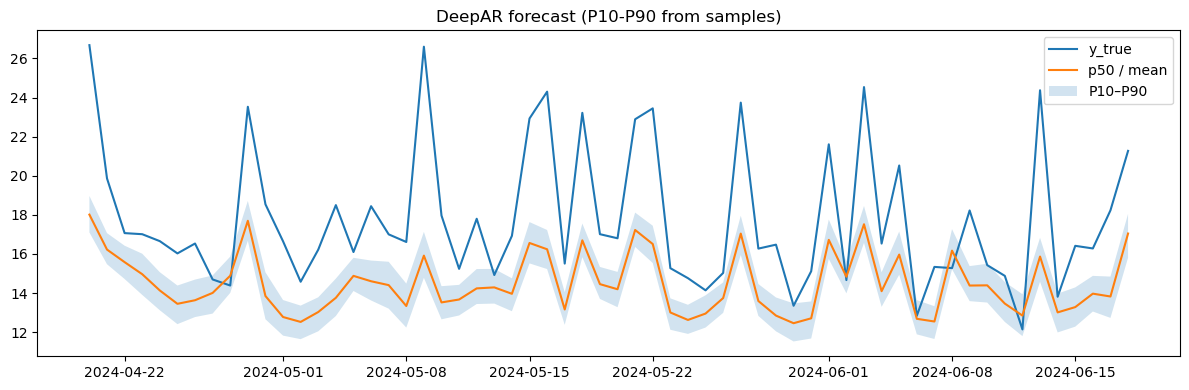


== DeepAR ==
           pinball_0.1: 0.4221
           pinball_0.5: 1.6805
           pinball_0.9: 2.2321
  coverage_80(P10-P90): 0.167
   mean_width(P10-P90): 1.8878
   WIS_proxy(10/50/90): 16.6324


In [60]:
# ── Plot + Evaluate ──
p10 = deepar_out["p10"].values
p50 = deepar_out["p50"].values
p90 = deepar_out["p90"].values

plot_forecast_with_interval(
    idx=deepar_out.index,
    y_true=deepar_out["y_true"].values,
    p50=p50, p10=p10, p90=p90,
    title="DeepAR forecast (P10-P90 from samples)"
)

m_deepar = evaluate_probabilistic_forecast(deepar_out["y_true"].values, p10, p50, p90, label="DeepAR")
print_metrics(m_deepar)

# Store multi-quantile predictions for reliability diagram
quantile_preds["DeepAR"] = {q: forecast.quantile(q) for q in EVAL_QUANTILES}

**Takeaways** (in the synthetic dataset): DeepAR was designed for training on hundreds/thousands of related time series simultaneously. The original paper (Salinas et al., 2020) explicitly frames it as learning a global model across many series, sharing statistical strength. Here we're asking it to learn from a single 840-point series — that's like training a neural network on 840 rows. It just doesn't have enough data to learn the covariate effects properly.

Specifically, our DGP has features that make this extra hard for a single-series RNN:

- Promo × price interaction — a nonlinear interaction that tree-based models learn trivially from feature splits, but an LSTM needs much more data to capture
- Heteroscedastic noise — the varying noise scale requires the model to learn conditional variance, which needs lots of examples
- Only ~100 promo days in training (12% × 840) — very few examples to learn the promo effect from.

The chart shows the model partly learned promo=higher, but it attenuates the effect (pushes it toward the mean) because it doesn't have enough promo observations to be confident about the full 3.0+ uplift.

**Note regarding covariates:** GluonTS requires these to cover the **full** series span (context + forecast horizon) in the test entry — which is fine here since both covariates are known-future. For observed-only covariates (e.g. real-time sensor readings), you'd use `feat_dynamic_real` only up to the forecast origin and let DeepAR's autoregressive structure handle the rest.

## 6) Deep SOTA for covariates: TFT (PyTorch Forecasting)

If we want one deep model that is purpose-built for:
- multi-horizon outputs
- known/unknown covariates
- categorical embeddings
- quantile forecasts

...TFT is the standard "practical SOTA" choice.

Here is a minimal runnable example on the same dataset:

In [61]:
# Build a single-series "group"
tft_df = df.reset_index().rename(columns={"ds":"time"})
tft_df["series"] = "S1"
tft_df["time_idx"] = np.arange(len(tft_df))

max_encoder_length = 60
max_prediction_length = h

training_cutoff = tft_df["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    tft_df[tft_df.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="y",
    group_ids=["series"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    # covariates:
    time_varying_known_reals=["time_idx", "promo", "price"],
    time_varying_unknown_reals=["y"],
    target_normalizer=GroupNormalizer(groups=["series"]),
)

validation = TimeSeriesDataSet.from_dataset(training, tft_df, predict=True, stop_randomization=True)

train_loader = training.to_dataloader(train=True, batch_size=16, num_workers=0)
val_loader = validation.to_dataloader(train=False, batch_size=64, num_workers=0)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=1e-3,
    hidden_size=16,
    attention_head_size=2,
    dropout=0.15,
    loss=QuantileLoss(quantiles=[0.1, 0.5, 0.9]),
)

trainer = pl.Trainer(
    max_epochs=80,
    accelerator="auto",
    gradient_clip_val=0.5,
    enable_checkpointing=False,
    logger=False,
)

trainer.fit(tft, train_loader, val_loader)

result = tft.predict(val_loader, mode="raw", return_x=True)
pred = result.output["prediction"][0].detach().cpu().numpy()  # first batch element

p10, p50, p90 = pred[:, 0], pred[:, 1], pred[:, 2]
tft_out = pd.DataFrame({"p10": p10, "p50": p50, "p90": p90, "y_true": test["y"].values}, index=test.index)
tft_out.head()

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.

   | Name                               | Type                            | Params | Mode  | FLOPs
--------------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train | 0    
1  | logging_metrics                    | ModuleList                      | 0      | train | 0    
2  | input_embeddings                   | MultiEmbedding                  | 0      | train | 0    
3  | prescalers                         | ModuleDict                      | 64     | train | 0    
4  | static_variable_selection          | VariableSelectionNetwork        | 0      | train

Epoch 79: 100%|██████████| 45/45 [00:05<00:00,  7.84it/s, train_loss_step=0.638, val_loss=1.260, train_loss_epoch=0.640]

`Trainer.fit` stopped: `max_epochs=80` reached.


Epoch 79: 100%|██████████| 45/45 [00:05<00:00,  7.83it/s, train_loss_step=0.638, val_loss=1.260, train_loss_epoch=0.640]


,p10,p50,p90,y_true
ds,,,,
2024-04-20,19.213875,21.590687,23.643375,26.676945
2024-04-21,14.441628,16.888626,18.882790,19.861670
2024-04-22,15.114524,17.392500,19.373371,17.066101
2024-04-23,15.457242,17.640570,19.591059,17.010509
2024-04-24,15.046298,17.369818,19.173004,16.655163


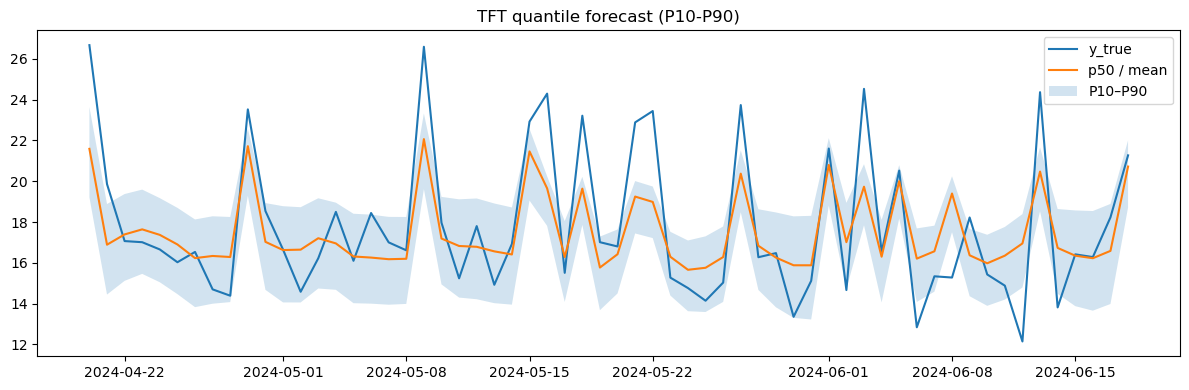


== TFT ==
           pinball_0.1: 0.3672
           pinball_0.5: 0.8643
           pinball_0.9: 0.6620
  coverage_80(P10-P90): 0.683
   mean_width(P10-P90): 3.9078
   WIS_proxy(10/50/90): 6.8743


In [62]:
# ── Plot + Evaluate ──
p10 = tft_out["p10"].values
p50 = tft_out["p50"].values
p90 = tft_out["p90"].values

plot_forecast_with_interval(
    idx=tft_out.index,
    y_true=tft_out["y_true"].values,
    p50=p50, p10=p10, p90=p90,
    title="TFT quantile forecast (P10-P90)"
)

m_tft = evaluate_probabilistic_forecast(tft_out["y_true"].values, p10, p50, p90, label="TFT")
print_metrics(m_tft)

# Store quantile predictions (TFT only trained with 3 quantiles)
quantile_preds["TFT"] = {0.1: tft_out["p10"].values, 0.5: tft_out["p50"].values, 0.9: tft_out["p90"].values}

**Production notes**

- TFT is heavier than GBDT. It shines when we have: many series, lots of covariates, nonlinear interactions, regime changes.
- We need disciplined backtesting and careful covariate governance (especially known-future features).

## 7) Amazon Chronos-2 (zero-shot) with covariates

Chronos-2 is a pretrained foundation model for time series forecasting that works zero-shot (no training needed). It can leverage covariates for improved forecasts.

In [63]:
# --- Build Chronos input frames (single series) ---
# Chronos expects columns: id, timestamp, target (+ optional covariates)
context_df = (
    train.reset_index()
         .rename(columns={"ds": "timestamp", "y": "target"})
         .assign(id="S1")[["id", "timestamp", "target", "promo", "price"]]
)

# Future covariates (known-in-advance): include timestamps + covariate columns, no target
future_df = (
    test.reset_index()
        .rename(columns={"ds": "timestamp"})
        .assign(id="S1")[["id", "timestamp", "promo", "price"]]
)

# --- Load pretrained Chronos-2 ---
# device_map="cpu" works everywhere (GPU: "cuda")
pipeline = Chronos2Pipeline.from_pretrained("amazon/chronos-2", device_map="cpu")

# --- Predict quantiles ---
pred_df = pipeline.predict_df(
    df=context_df,                    # context data with target + covariates
    future_df=future_df,              # enables covariate-informed forecasting
    prediction_length=h,
    quantile_levels=[0.1, 0.5, 0.9],
    id_column="id",
    timestamp_column="timestamp",
    target="target",
)

# pred_df typically contains: timestamp, predictions (central), and quantile columns "0.1","0.5","0.9"
pred_df = pred_df.sort_values("timestamp").set_index("timestamp")

p10 = pred_df["0.1"].values
p50 = pred_df["0.5"].values if "0.5" in pred_df.columns else pred_df["predictions"].values
p90 = pred_df["0.9"].values
y_true = test["y"].values

chronos_out = pd.DataFrame({"p10": p10, "p50": p50, "p90": p90, "y_true": y_true}, index=test.index)
chronos_out.head()

,p10,p50,p90,y_true
ds,,,,
2024-04-20,17.596001,21.454876,26.760080,26.676945
2024-04-21,14.416903,16.725975,19.687624,19.861670
2024-04-22,14.869823,17.265085,20.367409,17.066101
2024-04-23,14.016445,16.213299,18.971607,17.010509
2024-04-24,13.509766,15.478856,17.863895,16.655163


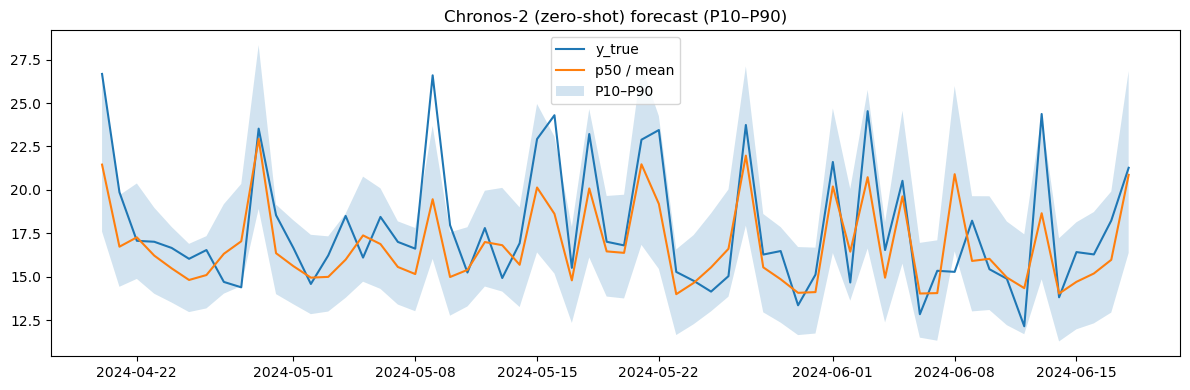


== Chronos-2 ==
           pinball_0.1: 0.4077
           pinball_0.5: 0.9061
           pinball_0.9: 0.3281
  coverage_80(P10-P90): 0.883
   mean_width(P10-P90): 6.3402
   WIS_proxy(10/50/90): 5.4913


In [64]:
# --- Plot ---
plot_forecast_with_interval(
    idx=test.index,
    y_true=y_true,
    p50=p50, p10=p10, p90=p90,
    title="Chronos-2 (zero-shot) forecast (P10–P90)"
)

# --- Evaluate ---
m_chronos = evaluate_probabilistic_forecast(y_true, p10, p50, p90, label="Chronos-2")
print_metrics(m_chronos)

# Store quantile predictions (Chronos predicted with 3 quantiles)
quantile_preds["Chronos-2"] = {0.1: chronos_out["p10"].values, 0.5: chronos_out["p50"].values, 0.9: chronos_out["p90"].values}

**Takeaway**: Chronos-2 behaved exactly like a well-calibrated foundation model used zero-shot - slightly less accurate and less sharp than the best ML models, but with good calibration (a bit overconservative) and the best overall probabilistic score so far.

**Production notes**

- Chronos-2 is zero-shot (no training needed), making it extremely fast to deploy for new series.
- Works well out-of-the-box but may underperform task-specific fine-tuned models on domains with strong patterns.
- Ideal for cold-start scenarios, exploratory analysis, or as a strong baseline before investing in custom models.

## 8) Simple Ensemble: Vincentization (average quantile predictions)

A powerful and often under-appreciated technique: **average the quantile predictions** across models at each quantile level. This is called Vincentization (after the 1912 paper by S.B. Vincent). In practice, this simple ensemble often beats every individual model because errors from different paradigms tend to cancel out.

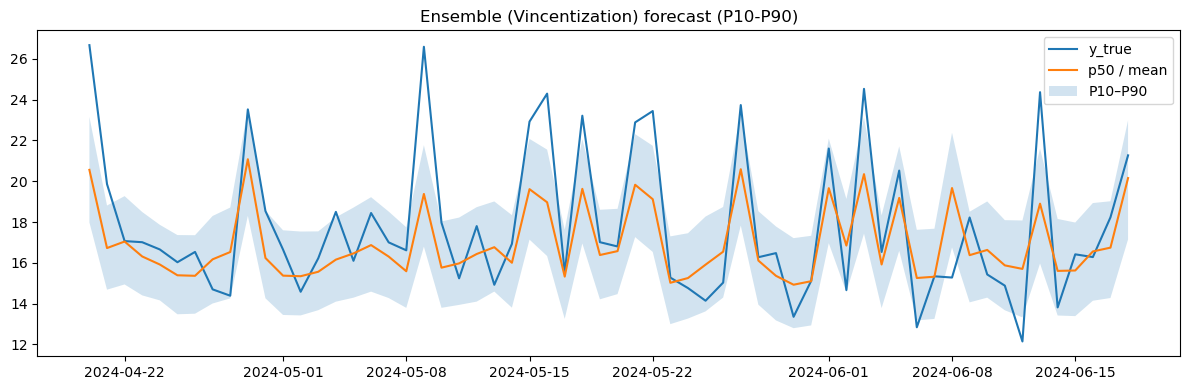


== Ensemble ==
           pinball_0.1: 0.3624
           pinball_0.5: 0.9185
           pinball_0.9: 0.5018
  coverage_80(P10-P90): 0.750
   mean_width(P10-P90): 4.5984
   WIS_proxy(10/50/90): 6.1578

Models averaged per quantile level: {0.05: 5, 0.1: 7, 0.2: 5, 0.3: 5, 0.5: 7, 0.7: 5, 0.8: 5, 0.9: 7, 0.95: 5}


In [65]:
# ── Vincentization: average quantile predictions across all models ──
# For each quantile level, average predictions from all models that produced it.
ensemble_qp = {}
for q in EVAL_QUANTILES:
    available = [np.asarray(quantile_preds[m][q])
                 for m in quantile_preds if q in quantile_preds[m]]
    if len(available) >= 2:
        ensemble_qp[q] = np.mean(available, axis=0)

# Extract P10/P50/P90 for standard eval
p10_ens, p50_ens, p90_ens = ensemble_qp[0.1], ensemble_qp[0.5], ensemble_qp[0.9]

# Plot
plot_forecast_with_interval(
    idx=test.index, y_true=test["y"].values,
    p50=p50_ens, p10=p10_ens, p90=p90_ens,
    title="Ensemble (Vincentization) forecast (P10-P90)"
)

# Evaluate
m_ensemble = evaluate_probabilistic_forecast(test["y"].values, p10_ens, p50_ens, p90_ens, label="Ensemble")
print_metrics(m_ensemble)

# Store for reliability / PIT / CRPS
quantile_preds["Ensemble"] = ensemble_qp

n_models_per_q = {q: sum(1 for m in quantile_preds if m != "Ensemble" and q in quantile_preds[m])
                  for q in EVAL_QUANTILES}
print(f"\nModels averaged per quantile level: {n_models_per_q}")

**Takeaway**: our ensemble improved calibration robustness vs raw ML models, but underperformed the best individual models because averaging diluted the strongest signals and inherited the calibration flaws of weaker members.

More specifically, Vincentization assumes all models contribute equally useful probabilistic information, but our model pool includes:

- good models (conformal GBDT, Chronos, TFT)
- mediocre models (SARIMAX)
- very bad models (DeepAR)

Averaging them dilutes signal.

Production ensembles normally use **weighted averaging**, not equal averaging, where weights are optimized using backtest performance.

## Calibration Section: Comparing All Methods

Once we've run all models, we can compare them side-by-side and provide more informative calibration diagnostics. (We also add approximate CRPS).

**Note:** SARIMAX, LightGBM, NGBoost, and Conformal include rolling-origin backtests above (refitting deep models per fold is expensive in a notebook). The comparison table below reflects single-holdout performance for all methods.

In [66]:
all_metrics = [m_sarimax, m_lgbm, m_ngboost, m_conformal, m_deepar, m_tft, m_chronos, m_ensemble]
metrics_df = pd.DataFrame(all_metrics).set_index("model")

In [67]:
# Add CRPS (approximate, from multi-quantile predictions)
model_name_map = {
    "SARIMAX": "SARIMAX", "LightGBM-Quantiles": "LightGBM", "NGBoost-Normal": "NGBoost",
    "Conformal": "Conformal", "DeepAR": "DeepAR", "TFT": "TFT", "Chronos-2": "Chronos-2",
    "Ensemble": "Ensemble",
}
for model_label in metrics_df.index:
    qp_key = model_name_map.get(model_label, model_label)
    if qp_key in quantile_preds:
        metrics_df.loc[model_label, "CRPS_approx"] = crps_from_quantiles(test["y"].values, quantile_preds[qp_key])

metrics_df.sort_values("CRPS_approx")

,pinball_0.1,pinball_0.5,pinball_0.9,coverage_80(P10-P90),mean_width(P10-P90),WIS_proxy(10/50/90),CRPS_approx
model,,,,,,,
Chronos-2,0.407670,0.906136,0.328129,0.883333,6.340227,5.491269,1.019229
TFT,0.367205,0.864276,0.661954,0.683333,3.907763,6.874349,1.103085
NGBoost-Normal,0.464194,0.839916,0.374550,0.533333,3.368104,5.873554,1.188854
Conformal,0.373898,1.095076,0.488051,0.766667,5.703396,6.499899,1.317992
Ensemble,0.362394,0.918480,0.501778,0.750000,4.598441,6.157822,1.318049
LightGBM-Quantiles,0.397410,0.976830,0.632814,0.633333,4.491095,7.104779,1.401115
SARIMAX,0.380644,0.993157,0.587944,0.800000,6.490713,6.829254,1.404057
DeepAR,0.422145,1.680505,2.232127,0.166667,1.887789,16.632368,2.757240


### Reliability Diagram

A reliability diagram shows whether predicted quantiles match observed frequencies. Each point represents one quantile level: the x-axis is the nominal level (e.g. 0.1), the y-axis is the fraction of observations that actually fell below that prediction. Perfect calibration = diagonal.

Methods with 9 quantile levels (SARIMAX, LightGBM, NGBoost, Conformal, DeepAR) give a richer picture; TFT and Chronos-2 show 3 points since they were trained/predicted with only P10/P50/P90.

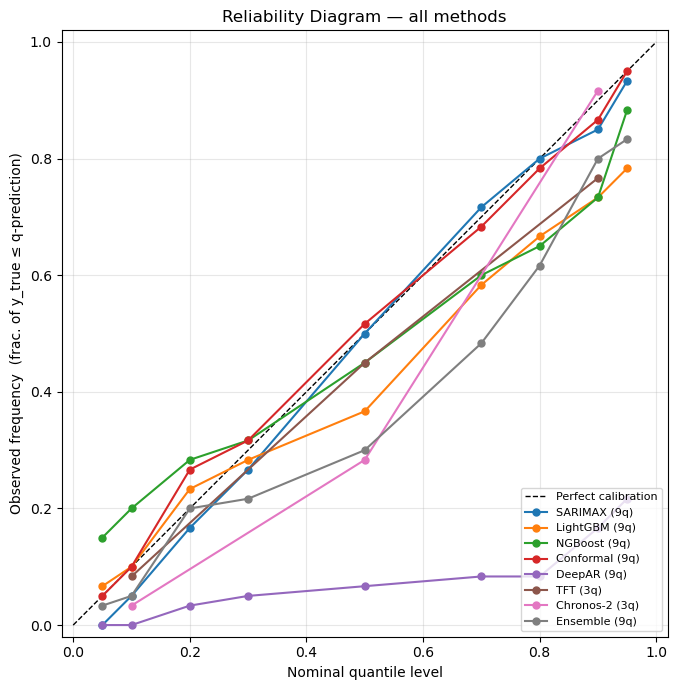

In [68]:
plot_reliability_diagram(test["y"].values, quantile_preds,
                        title="Reliability Diagram — all methods")

### PIT Histogram (Probability Integral Transform)

If a model is well-calibrated, the CDF-transformed residuals (PIT values) should be Uniform(0,1). A U-shaped histogram → underconfident intervals (too wide). An inverted-U → overconfident (too narrow). Skew → systematic bias.

**Note:** PIT requires enough quantile levels to approximate the CDF via interpolation — methods with only 3 quantiles are skipped.

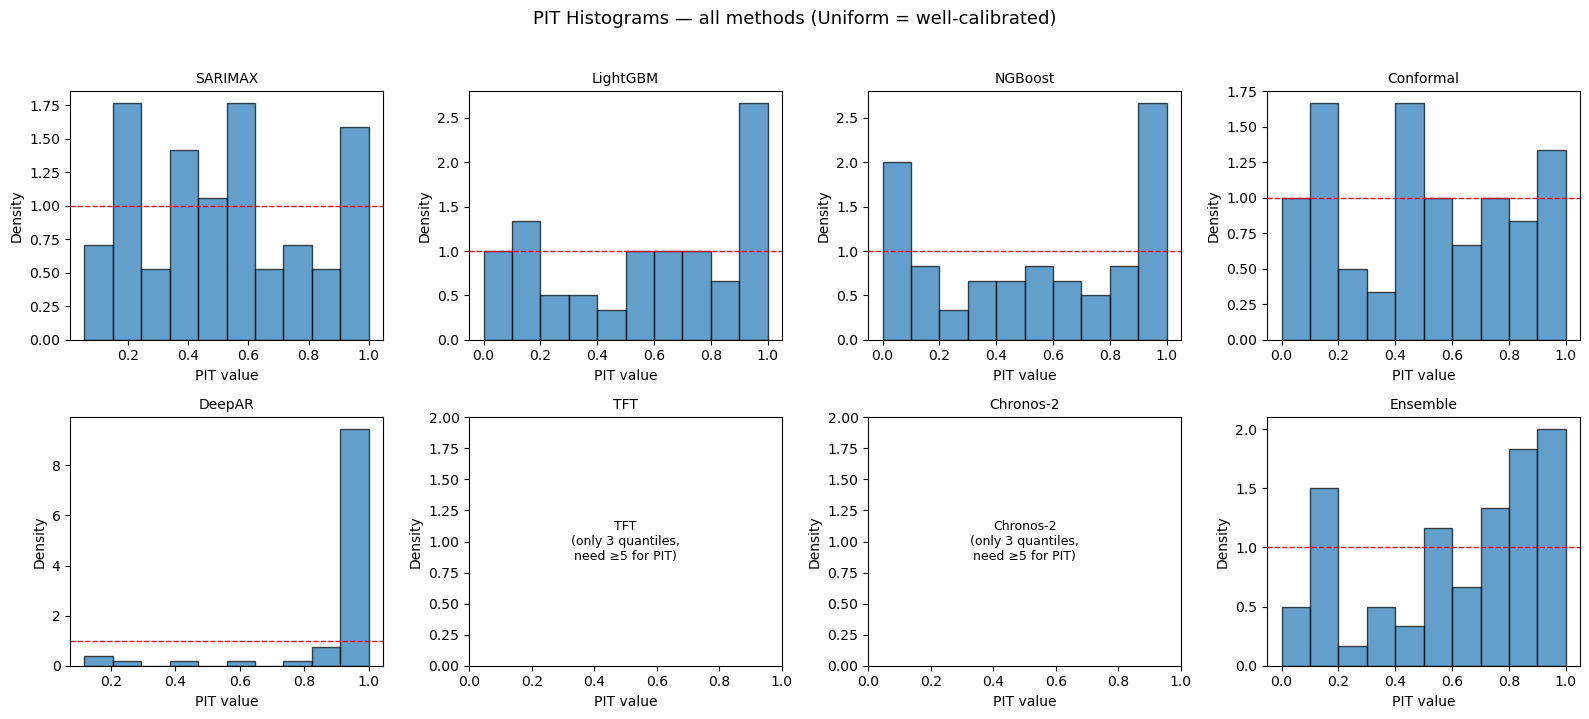

In [69]:
plot_pit_histogram(test["y"].values, quantile_preds,
                   title="PIT Histograms — all methods (Uniform = well-calibrated)")

### Rolling Coverage Curve

A rolling coverage curve shows how coverage varies over time, which is more informative than a single coverage number.

In [70]:
def rolling_coverage_curve(y_true, lo, hi, window=14):
    y = np.asarray(y_true)
    inside = ((y >= np.asarray(lo)) & (y <= np.asarray(hi))).astype(float)
    return pd.Series(inside).rolling(window).mean().values

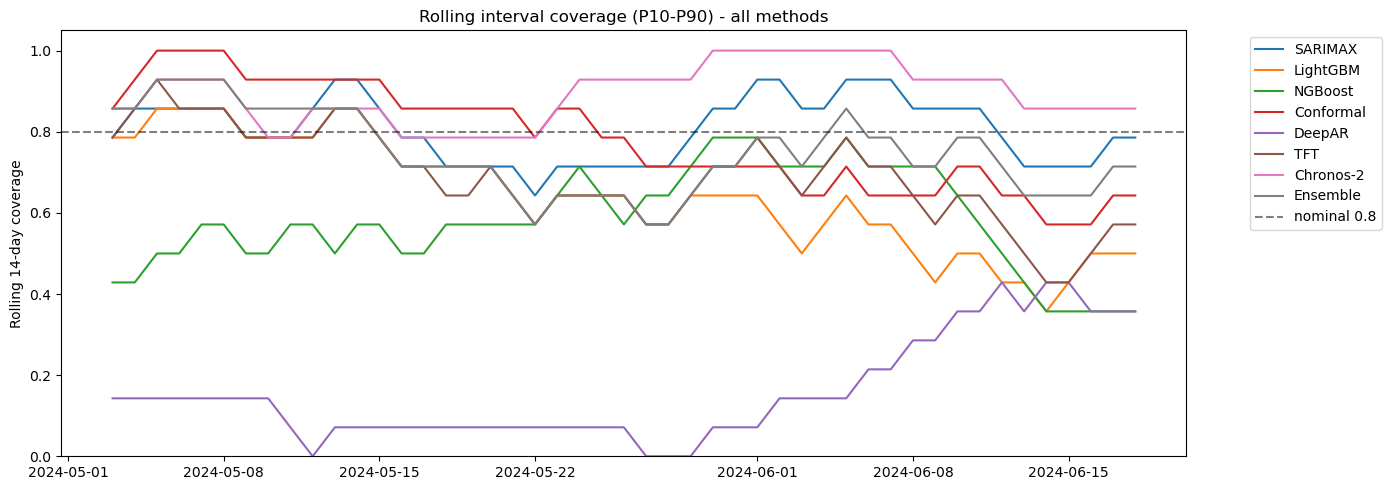

In [71]:
# Collect P10/P90 for all methods
ci_80_sarimax = res.get_forecast(steps=h, exog=test[exog_cols]).conf_int(alpha=0.20)

coverage_data = {
    "SARIMAX":    (ci_80_sarimax.iloc[:, 0].values, ci_80_sarimax.iloc[:, 1].values),
    "LightGBM":   (lgb_out["p10"].values, lgb_out["p90"].values),
    "NGBoost":    (ngb_out["p10"].values, ngb_out["p90"].values),
    "Conformal":  (conf_out["p10"].values, conf_out["p90"].values),
    "DeepAR":     (deepar_out["p10"].values, deepar_out["p90"].values),
    "TFT":        (tft_out["p10"].values, tft_out["p90"].values),
    "Chronos-2":  (chronos_out["p10"].values, chronos_out["p90"].values),
    "Ensemble":   (ensemble_qp[0.1], ensemble_qp[0.9]),
}

plt.figure(figsize=(14, 5))
for label, (lo, hi) in coverage_data.items():
    cov_curve = rolling_coverage_curve(test["y"].values, lo, hi, window=14)
    plt.plot(test.index, cov_curve, label=label)

plt.axhline(0.8, linestyle="--", color="black", alpha=0.5, label="nominal 0.8")
plt.ylim(0, 1.05)
plt.ylabel("Rolling 14-day coverage")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.title("Rolling interval coverage (P10-P90) - all methods")
plt.tight_layout()
plt.show()

Note on the time window in the chart above (on the synthetic dataset):

- The full dataset is 900 daily observations starting from 2022-01-01, so it runs from Jan 1, 2022 → ~Jun 18, 2024
- The test set is only the last 60 days (h = 60), which spans roughly Apr 20, 2024 → Jun 18, 2024
- The rolling coverage curve plots on those 60 days — but with a 14-day rolling window (window=14), the first 13 values are NaN. So the plotted curve effectively starts on ~May 3, 2024.